In [60]:
import numpy as np
import pandas as pd
from transformers import BertForSequenceClassification
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pprint as pp

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from textcat.ml.tokenizer.bert_tokenizer import GeneralTokenizer
from textcat.ml.tokenizer.adsorption_tokenizer import AdsorptionTokenizer
from textcat.ml.dataset.adsorption_text_dataset import AdsorptionTextDataset

In [13]:
model = BertForSequenceClassification.from_pretrained('../models/finetuning/alldata_matformula_bert_bs64/checkpoint-70000',
                                                      torch_dtype=torch.float32,
                                                      local_files_only=True)
tokenizer = GeneralTokenizer('../data/vocabularies/vocabulary_formula.txt', 
                             AdsorptionTokenizer('../data/tokenizer_configs/config.toml')
                             )

### Datasets (Pandas)

In [4]:
df_train_all = pd.read_parquet('../data/is2res_train_val_test_dfs/all/train/data.parquet')
df_id = pd.read_parquet('../data/is2res_train_val_test_dfs/all/val_id/data.parquet')
df_ood_ads = pd.read_parquet('../data/is2res_train_val_test_dfs/all/val_ood_ads/data.parquet')
df_ood_cat = pd.read_parquet('../data/is2res_train_val_test_dfs/all/val_ood_cat/data.parquet')
df_ood_both = pd.read_parquet('../data/is2res_train_val_test_dfs/all/val_ood_both/data.parquet')

Length of different datasets

In [5]:
print(len(df_train_all))
print(len(df_id))
print(len(df_ood_ads))
print(len(df_ood_cat))
print(len(df_ood_both))

460328
24943
24961
24963
24987


### Torch Datasets from Dataframes

In [6]:
dataset_train = AdsorptionTextDataset(df_train_all, tokenizer, 50)  # It contains the scaler for y
dataset_val_id = AdsorptionTextDataset(df_id, tokenizer, 50)  # NB they contain the input strings!
dataset_val_ood_ads = AdsorptionTextDataset(df_ood_ads, tokenizer, 50)
dataset_val_ood_cat = AdsorptionTextDataset(df_ood_cat, tokenizer, 50)
dataset_val_ood_both = AdsorptionTextDataset(df_ood_both, tokenizer, 50)

### Torch Dataloaders from Torch Datasets

In [7]:
BATCH_SIZE = 64  # Randomly taken

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
loader_id = DataLoader(dataset_val_id, batch_size=BATCH_SIZE, shuffle=False)
loader_ood_ads = DataLoader(dataset_val_ood_ads, batch_size=BATCH_SIZE, shuffle=False)
loader_ood_cat = DataLoader(dataset_val_ood_cat, batch_size=BATCH_SIZE, shuffle=False)
loader_ood_both = DataLoader(dataset_val_ood_both, batch_size=BATCH_SIZE, shuffle=False)

## Evaluate

## Case 1: Scaled output

In [14]:
# Get scaler (sklearn scaler)

scaler = torch.load('../models/finetuning/alldata_matformula_bert_bs64/scaler.pt')

/tmp/ipykernel_769/3590346951.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scaler = torch.load('../models/finetuning/alldata_matformula_bert_bs64/scaler.pt')
/home/sm

### Batch-wise evaluation

#### Training data

In [15]:
y_pred_train, y_true_train = [], []

with torch.no_grad():
    for batch in loader_train:
        y_pred_train.extend(scaler.inverse_transform(model(**batch)['logits']))

#### Model trained without target scaling

In [26]:
y_pred_train, y_true_train = [], []

with torch.no_grad():
    for batch in loader_train:
        y_pred_train.extend(model(**batch)['logits'])

#### Validation sets

In [16]:
y_pred_id, y_pred_ood_ads, y_pred_ood_cat, y_pred_ood_both = [], [], [], []

with torch.no_grad():
    for batch in loader_id:      
        y_pred_id.extend(scaler.inverse_transform(model(**batch)['logits']))
    print("Done")
    for batch in loader_ood_ads:      
        y_pred_ood_ads.extend(scaler.inverse_transform(model(**batch)['logits']))
    print("Done")
    for batch in loader_ood_cat:      
        y_pred_ood_cat.extend(scaler.inverse_transform(model(**batch)['logits']))
    print("Done")
    for batch in loader_ood_both:      
        y_pred_ood_both.extend(scaler.inverse_transform(model(**batch)['logits']))

Done
Done
Done


#### Unscaled model

In [25]:
y_pred_id, y_pred_ood_ads, y_pred_ood_cat, y_pred_ood_both = [], [], [], []

with torch.no_grad():
    for batch in loader_id:      
        y_pred_id.extend(model(**batch)['logits'])
    print("Done")
    for batch in loader_ood_ads:      
        y_pred_ood_ads.extend(model(**batch)['logits'])
    print("Done")
    for batch in loader_ood_cat:      
        y_pred_ood_cat.extend(model(**batch)['logits'])
    print("Done")
    for batch in loader_ood_both:      
        y_pred_ood_both.extend(model(**batch)['logits'])

Done
Done
Done


In [17]:
df_train_all['pred'] = y_pred_train
df_id['pred'] = y_pred_id
df_ood_ads['pred'] = y_pred_ood_ads
df_ood_cat['pred'] = y_pred_ood_cat
df_ood_both['pred'] = y_pred_ood_both

In [18]:
mae_train = mean_absolute_error(df_train_all['eads_eV'], df_train_all['pred'])
mae_id = mean_absolute_error(df_id['eads_eV'], df_id['pred'])
mae_ood_ads = mean_absolute_error(df_ood_ads['eads_eV'], df_ood_ads['pred'])
mae_ood_cat = mean_absolute_error(df_ood_cat['eads_eV'], df_ood_cat['pred'])
mae_ood_both = mean_absolute_error(df_ood_both['eads_eV'], df_ood_both['pred'])

rmse_train = mean_squared_error(df_train_all['eads_eV'], df_train_all['pred'], squared=False)
rmse_id = mean_squared_error(df_id['eads_eV'], df_id['pred'], squared=False)
rmse_ood_ads = mean_squared_error(df_ood_ads['eads_eV'], df_ood_ads['pred'], squared=False)
rmse_ood_cat = mean_squared_error(df_ood_cat['eads_eV'], df_ood_cat['pred'], squared=False)
rmse_ood_both = mean_squared_error(df_ood_both['eads_eV'], df_ood_both['pred'], squared=False)

r2_train = r2_score(df_train_all['eads_eV'], df_train_all["pred"])
r2_id = r2_score(df_id['eads_eV'], df_id['pred'])
r2_ood_ads = r2_score(df_ood_ads['eads_eV'], df_ood_ads['pred'])
r2_ood_cat = r2_score(df_ood_cat['eads_eV'], df_ood_cat['pred'])
r2_ood_both = r2_score(df_ood_both['eads_eV'], df_ood_both['pred'])

print(mae_train)
print(mae_id)
print(mae_ood_ads)
print(mae_ood_cat)
print(mae_ood_both)

print(r2_train)
print(r2_id)
print(r2_ood_ads)
print(r2_ood_cat)
print(r2_ood_both)

/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in ve

0.8294655141855346
0.8376729831040185
1.0487089840237152
0.8180023104098608
0.9857594483309832
0.7138756208697628
0.705369366221988
0.5924907508273043
0.723680870342694
0.5536051831443499


In [19]:
df_train_all['pred'] = df_train_all['pred'].apply(lambda x: x.item())
df_id['pred'] = df_id['pred'].apply(lambda x: x.item())
df_ood_ads['pred'] = df_ood_ads['pred'].apply(lambda x: x.item())
df_ood_cat['pred'] = df_ood_cat['pred'].apply(lambda x: x.item())
df_ood_both['pred'] = df_ood_both['pred'].apply(lambda x: x.item())

In [20]:
df_train_all["error"] = df_train_all["eads_eV"] - df_train_all["pred"]
df_id["error"] = df_id["eads_eV"] - df_id["pred"]
df_ood_ads["error"] = df_ood_ads["eads_eV"] - df_ood_ads["pred"]
df_ood_cat["error"] = df_ood_cat["eads_eV"] - df_ood_cat["pred"]
df_ood_both["error"] = df_ood_both["eads_eV"] - df_ood_both["pred"]

In [21]:
df_train_all.head()

,sid,anomaly,class,C,H,O,N,ads_size,ads_symbols,ads_id,...,bulk_nelems,bulk_natoms,slices,h,k,l,hkl,eads_eV,pred,error
0,2472718,0,0,0,1,0,1,2,*NH,74,...,2,28,Al Al Al Al Al Al Al Al Al Al Al Al Al Al Al A...,2,1,1,211,-0.025550,-0.398150,0.372600
1,1747243,0,2,2,1,2,0,5,*COCHO,22,...,3,5,Zr Zr Se N N 0 4 ooo 0 4 o-o 0 4 +oo 0 3 ooo 0...,2,2,1,221,-1.837069,-2.912860,1.075791
2,1824821,0,2,0,2,1,0,3,*OH2,3,...,3,7,Ag P Pd Pd Pd Pd Pd 0 2 ooo 0 2 o+o 0 2 +oo 0 ...,1,0,1,101,-0.152283,-0.181378,0.029095
3,1324413,0,0,2,5,1,0,8,*OCH2CH3,53,...,2,18,Hf Hf Hf Hf Hf Hf Hf Hf Hf Hf Sn Sn Sn Sn Sn S...,2,0,1,201,-6.227071,-5.689769,-0.537302
4,1219873,1,0,1,2,0,0,3,*CH2,9,...,2,8,Tc Tc Os Os Os Os Os Os 0 7 -oo 0 7 o+o 0 5 -o...,1,0,2,102,-2.453840,-1.976540,-0.477300


In [22]:
df_id['true_scaled'] = scaler.transform(df_id['eads_eV'].values.reshape(-1,1))
df_id['pred_scaled'] = scaler.transform(df_id['pred'].values.reshape(-1,1))

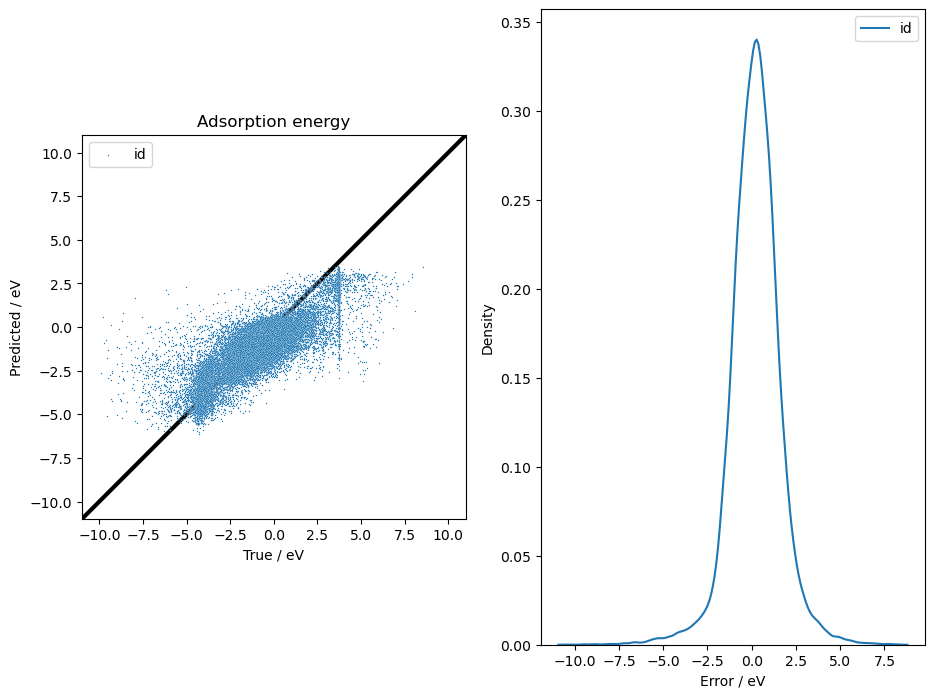

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24/2.54, 18/2.54))

sns.scatterplot(df_ood_ads, x='eads_eV', y='pred', ax=ax[0], legend=True, s=1)
# sns.scatterplot(df_ood_ads, x='eads_eV', y='pred', ax=ax[0], legend=True)
# sns.scatterplot(df_ood_cat, x='eads_eV', y='pred', ax=ax[0], legend=True)
# sns.scatterplot(df_ood_both, x='eads_eV', y='pred', ax=ax[0], legend=True)

ax[0].set_xlabel("True / eV")
ax[0].set_ylabel("Predicted / eV")
ax[0].set_title("Adsorption energy")
ax[0].set_xlim(-11, 11)
ax[0].set_ylim(-11, 11)

ax[0].legend(['id', 'ood_ads', 'ood_cat', 'ood_both'])
ax[0].set_aspect("equal")

x = np.linspace(-11, 11, 1000)
y = np.linspace(-11, 11, 1000)

ax[0].plot(x, y, lw=3, zorder=-1, color='black')

sns.kdeplot(df_ood_ads, x='error', ax=ax[1])
# sns.kdeplot(df_ood_ads, x='error', ax=ax[1])
# sns.kdeplot(df_ood_cat, x='error', ax=ax[1])
# sns.kdeplot(df_ood_both, x='error', ax=ax[1])

ax[1].legend(["id", "ood_ads", "ood_cat", "ood_both"])
ax[1].set_xlabel("Error / eV")

plt.tight_layout()

<Axes: xlabel='eads_eV', ylabel='Density'>

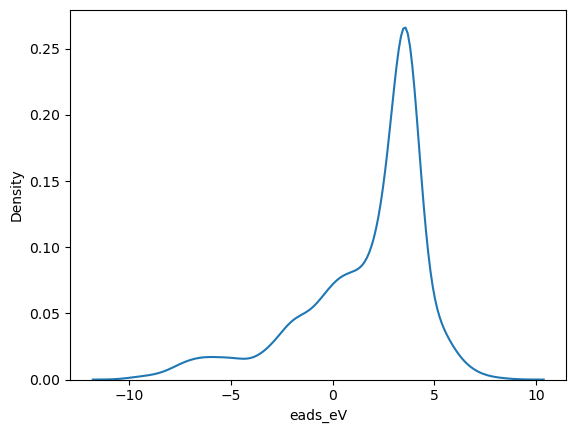

In [120]:
sns.kdeplot(df_ood_ads[df_ood_ads['ads_symbols'] == '*ONOH'], x='eads_eV')

In [118]:
ter = df_ood_ads[df_ood_ads['eads_eV'].between(3.5, 3.75)].groupby(["ads_symbols"]).count()
ter

,sid,anomaly,class,C,H,O,N,ads_size,ads_id,ads_smiles,...,bulk_nelems,bulk_natoms,slices,h,k,l,hkl,eads_eV,pred,error
ads_symbols,,,,,,,,,,,,,,,,,,,,,
*CH,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
*COH,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
*NH2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
*ONOH,733,733,733,733,733,733,733,733,733,733,...,733,733,733,733,733,733,733,733,733,733


<Axes: xlabel='eads_eV', ylabel='Density'>

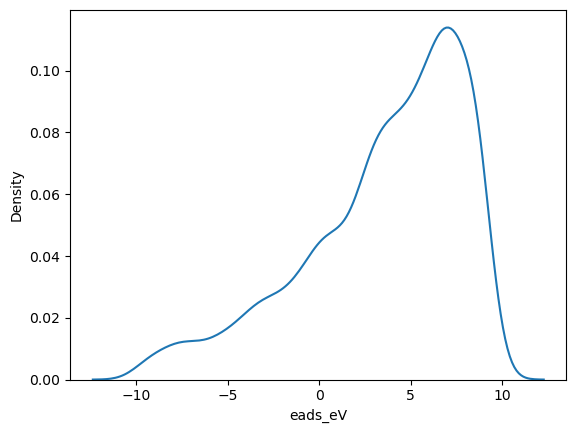

In [73]:
sns.kdeplot(df_train_all[df_train_all['ads_symbols'] == '*NO2NO2'], x='eads_eV')

In [75]:
df_train_all[df_train_all['ads_symbols'] == '*NO2NO2']['eads_eV'].describe()

count    4814.000000
mean        3.555075
std         4.385002
min        -9.975310
25%         0.980003
50%         4.560897
75%         7.022384
max         9.871051
Name: eads_eV, dtype: float64

In [53]:
dataset_train[169]['input_ids']

tensor([103,  72,  76,  12,  72,  76,  12, 121,  89,  42,  54,  42, 121, 110,
        113, 119, 106, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105])

In [56]:
tokenizer.convert_ids_to_tokens(dataset_train[169]['input_ids'])

['[CLS]',
 'N_MOL',
 'O_MOL',
 '2',
 'N_MOL',
 'O_MOL',
 '2',
 '|',
 'Se',
 '8',
 'Cl',
 '8',
 '|',
 'h2',
 'k0',
 'l1',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [63]:
df_train_all[df_train_all['eads_eV'] > 6].head(30)

,sid,anomaly,class,C,H,O,N,ads_size,ads_symbols,ads_id,...,bulk_mpid,bulk_id,slices,h,k,l,hkl,eads_eV,pred,error
169,582159,2,2,0,0,4,2,6,*NO2NO2,67,...,mp-504825,2532,Se Se Se Se Se Se Se Se Cl Cl Cl Cl Cl Cl Cl C...,2,0,1,201,8.726665,5.637171,3.089493
269,1958740,1,0,0,0,4,2,6,*NO2NO2,67,...,mp-571160,3808,Tl Tl Tl Tl Pt Pt 0 2 o-o 0 2 +-o 0 2 ooo 0 4 ...,2,1,2,212,6.505560,5.817790,0.687771
311,1533862,1,1,0,0,4,2,6,*NO2NO2,67,...,mp-754,1871,Te Te Te Te Te Te Te Te Rh Rh Rh Rh 0 10 ooo 0...,1,1,0,110,8.897905,5.755135,3.142770
446,1184330,1,2,0,0,4,2,6,*NO2NO2,67,...,mp-760,656,Fe Fe Se Se Se Se 0 4 --o 0 4 o-o 0 5 -o- 0 5 ...,2,1,0,210,6.870468,5.832375,1.038093
487,1598489,1,1,0,0,4,2,6,*NO2NO2,67,...,mp-866805,7870,Sr Sr Sr Sr Sn Sn Sn Sn Sn Sn Sn Sn Sn Sn Sn S...,2,1,1,211,6.274873,5.853354,0.421518
1011,880900,1,2,0,0,4,2,6,*NO2NO2,67,...,mp-1216134,9734,Y Y P P P P P P P Rh Rh Rh Rh Rh Rh Rh Rh Rh R...,1,0,2,102,6.034958,5.799452,0.235506
1301,1649572,1,1,0,0,4,2,6,*NO2NO2,67,...,mp-1220085,11209,Ni Ni Ni Te Te Te Te 0 2 -oo 0 5 -oo 0 5 ooo 0...,1,1,0,110,6.941931,5.781433,1.160498
1390,651392,1,1,0,0,4,2,6,*NO2NO2,67,...,mp-1102616,1764,Co Co Co Co Co Co Co Co Ge Ge Ge Ge 0 2 o-o 0 ...,0,1,1,011,6.610340,5.826010,0.784330
1445,93696,0,3,0,0,3,1,4,*NO3,78,...,mp-22871,2483,Zr Zr Cl Cl Cl Cl Cl Cl 0 3 --o 0 7 ooo 0 2 -o...,1,1,0,110,6.234316,5.595752,0.638564
1487,1219122,1,1,0,0,4,2,6,*NO2NO2,67,...,mp-571640,925,Ge Ge Ge Ge Ge Ge Ge Ge Ge Ge Ge Ge Pt Pt Pt P...,2,1,2,212,7.023482,5.780691,1.242791


In [64]:
df_train_all['ads_symbols'].unique()

array(['*NH', '*COCHO', '*OH2', '*OCH2CH3', '*CH2', '*CCHOH', '*H',
       '*OCH3', '*OH', '*CCH3', '*C*C', '*NO', '*NO2', '*CHOHCH2',
       '*NONH', '*CCH2', '*CHCH2', '*C', '*ONN(CH3)2', '*CHCH2OH', '*CH4',
       '*OHCH3', '*O', '*CH*CH', '*N2', '*CHOH', '*COCH3', '*CCH',
       '*CHOHCH2OH', '*COHCHOH', '*CHCHOH', '*COHCH3', '*NHNH',
       '*CHOHCHOH', '*ONH', '*CHCHO', '*NH3', '*CHCO', '*CCO', '*CH3',
       '*COHCHO', 'CH2*CO', '*CN', '*OCH2CHOH', '*COHCH2OH', '*CHOHCH3',
       '*CH*COH', '*OHNNCH3', '*CCH2OH', '*OHNH2', '*COCH2O', '*CH2CH3',
       '*N', '*CHO*CHO', '*CCHO', '*CH2*O', '*NO3', '*CHOCHOH', '*N*NH',
       '*CH2OH', '*OHCH2CH3', '*OCHCH3', '*N*NO', '*CH2CH2OH', '*ONNH2',
       '*NO2NO2', '*CHOCH2OH', '*COHCOH'], dtype=object)

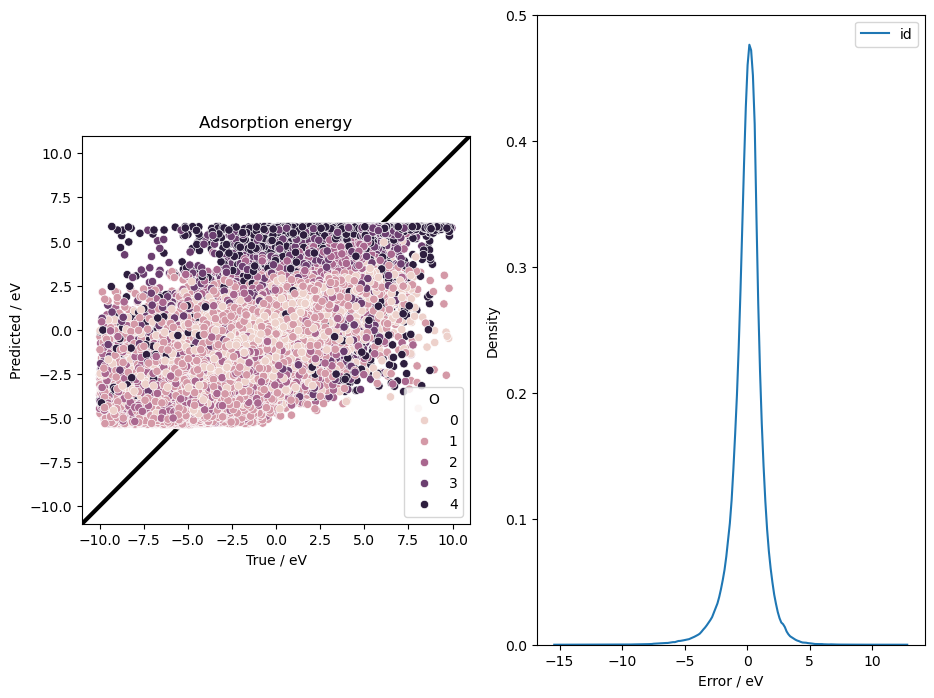

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24/2.54, 18/2.54))

sns.scatterplot(df_train_all, x='eads_eV', y='pred', hue='O', ax=ax[0])

ax[0].set_xlabel("True / eV")
ax[0].set_ylabel("Predicted / eV")
ax[0].set_title("Adsorption energy")
ax[0].set_xlim(-11, 11)
ax[0].set_ylim(-11, 11)

ax[0].set_aspect("equal")

x = np.linspace(-11, 11, 1000)
y = np.linspace(-11, 11, 1000)

ax[0].plot(x, y, lw=3, zorder=-1, color='black')

sns.kdeplot(df_train_all, x='error', ax=ax[1])
ax[1].legend(["id", "ood_ads", "ood_cat", "ood_both"])
ax[1].set_xlabel("Error / eV")

plt.tight_layout()

In [52]:
df_train_all['bulk_symbols'].unique()[76]

'Si8Nb24'

### R2 by adsorbate

In [68]:
adsorbates = df_train_all['ads_symbols'].unique()
r2 = np.zeros(len(adsorbates))
n = np.zeros(len(adsorbates))

adsorbate_dict = {}

for i, adsorbate in enumerate(adsorbates):
    di = df_train_all[df_train_all['ads_symbols'] == adsorbate]
    r2[i] = r2_score(di['eads_eV'], di['pred'])
    n[i] = len(di)
    adsorbate_dict[adsorbate] = {'r2': r2[i], 'n': n[i]}

In [69]:
pp.pprint(adsorbate_dict)

{'*C': {'n': 10874.0, 'r2': 0.520242015788559},
 '*C*C': {'n': 8319.0, 'r2': 0.5049443189280384},
 '*CCH': {'n': 6157.0, 'r2': 0.4219997147259491},
 '*CCH2': {'n': 7264.0, 'r2': 0.4324138948278772},
 '*CCH2OH': {'n': 6558.0, 'r2': 0.45779857039227956},
 '*CCH3': {'n': 8590.0, 'r2': 0.46746343827636627},
 '*CCHO': {'n': 6811.0, 'r2': 0.5444298126005336},
 '*CCHOH': {'n': 6661.0, 'r2': 0.3843023599913019},
 '*CCO': {'n': 5625.0, 'r2': 0.45999186955555127},
 '*CH*CH': {'n': 7698.0, 'r2': 0.44102242192900165},
 '*CH*COH': {'n': 3950.0, 'r2': 0.3589618110133772},
 '*CH2': {'n': 9186.0, 'r2': 0.3209096697250232},
 '*CH2*O': {'n': 7427.0, 'r2': 0.373346937724219},
 '*CH2CH2OH': {'n': 6469.0, 'r2': 0.24879461678174108},
 '*CH2CH3': {'n': 7135.0, 'r2': 0.08972764224312935},
 '*CH2OH': {'n': 6804.0, 'r2': 0.30401456247978476},
 '*CH3': {'n': 8177.0, 'r2': 0.1250943542916878},
 '*CH4': {'n': 6937.0, 'r2': -0.10435832785603605},
 '*CHCH2': {'n': 6533.0, 'r2': 0.25487012042980406},
 '*CHCH2OH': {'n

### R2 by surface 

In [70]:
surfaces = df_train_all['hkl'].unique()
r2 = np.zeros(len(surfaces))
n = np.zeros(len(surfaces))

hkl_dict = {}

for i, hkl in enumerate(surfaces):
    di = df_train_all[df_train_all['hkl'] == hkl]
    r2[i] = r2_score(di['eads_eV'], di['pred'])
    n[i] = len(di)
    hkl_dict[hkl] = {'r2': r2[i], 'n': n[i]}

In [71]:
pp.pprint(hkl_dict)

{'001': {'n': 18173.0, 'r2': 0.5577484877975344},
 '01-1': {'n': 195.0, 'r2': 0.6088962374670965},
 '01-2': {'n': 161.0, 'r2': 0.720893378785655},
 '010': {'n': 6949.0, 'r2': 0.6282585781677126},
 '011': {'n': 9422.0, 'r2': 0.6950356276038692},
 '012': {'n': 6847.0, 'r2': 0.70702029953793},
 '02-1': {'n': 160.0, 'r2': 0.7411761134157611},
 '021': {'n': 8338.0, 'r2': 0.6925167438009838},
 '1-1-1': {'n': 201.0, 'r2': 0.6381225498498897},
 '1-1-2': {'n': 133.0, 'r2': 0.7161765913355437},
 '1-10': {'n': 209.0, 'r2': 0.8031942834736366},
 '1-11': {'n': 220.0, 'r2': 0.7558400986121545},
 '1-12': {'n': 238.0, 'r2': 0.7618415751234527},
 '1-2-1': {'n': 157.0, 'r2': 0.7634921959633839},
 '1-2-2': {'n': 158.0, 'r2': 0.7351049875241376},
 '1-20': {'n': 172.0, 'r2': 0.6700856923437705},
 '1-21': {'n': 151.0, 'r2': 0.7231447212632711},
 '1-22': {'n': 140.0, 'r2': 0.7447483644246484},
 '10-1': {'n': 3405.0, 'r2': 0.7067211888694972},
 '10-2': {'n': 3617.0, 'r2': 0.6531139037752796},
 '100': {'n': 40

### R2 by material

In [82]:
materials = df_train_all['bulk_symbols'].unique()
r2 = np.zeros(len(materials))
n = np.zeros(len(materials))

material_dict = {}

for i, mat in enumerate(materials):
    di = df_train_all[df_train_all['bulk_symbols'] == mat]
    r2[i] = r2_score(di['eads_eV'], di['pred'])
    n[i] = len(di)
    material_dict[mat] = {'r2': r2[i], 'n': n[i]}

/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/smorandi/miniconda3/envs/tcat/lib/python3.10/site-packages/sklearn/metrics/_re

In [84]:
pp.pprint(material_dict)

{'Ag': {'n': 83.0, 'r2': 0.9335509513853217},
 'Ag12As4S12': {'n': 12.0, 'r2': 0.8738476575731872},
 'Ag12Sb4S12': {'n': 15.0, 'r2': 0.8929686838741171},
 'Ag12Te8Au4': {'n': 3.0, 'r2': 0.889163474145121},
 'Ag14Te7': {'n': 91.0, 'r2': 0.8437863211205027},
 'Ag2Au2Cl8': {'n': 11.0, 'r2': 0.8304208448093653},
 'Ag2Bi2S4': {'n': 39.0, 'r2': 0.664357902298464},
 'Ag2Bi2Se4': {'n': 16.0, 'r2': 0.8858154560142358},
 'Ag2Cl2': {'n': 42.0, 'r2': 0.16164592462615057},
 'Ag2Hf2': {'n': 161.0, 'r2': 0.14371976377728146},
 'Ag2S': {'n': 35.0, 'r2': 0.8208388926445634},
 'Ag2Sb2Se4': {'n': 23.0, 'r2': 0.926481033697853},
 'Ag2Se': {'n': 35.0, 'r2': 0.8880017069284027},
 'Ag2Te': {'n': 58.0, 'r2': 0.8340227981559568},
 'Ag2Te8Au2': {'n': 11.0, 'r2': 0.8999342863156425},
 'Ag3': {'n': 112.0, 'r2': 0.9562599991715918},
 'Ag3Au': {'n': 238.0, 'r2': 0.9665770181767346},
 'Ag3Bi3Te6': {'n': 16.0, 'r2': 0.9581486739748072},
 'Ag3Bi7S12': {'n': 26.0, 'r2': 0.8020880226207123},
 'Ag3In': {'n': 105.0, 'r2':

In [85]:
dfr_adsorbate = pd.DataFrame(adsorbate_dict).T
dfr_material = pd.DataFrame(material_dict).T
dfr_surface = pd.DataFrame(hkl_dict).T

(0.0, 8.0)

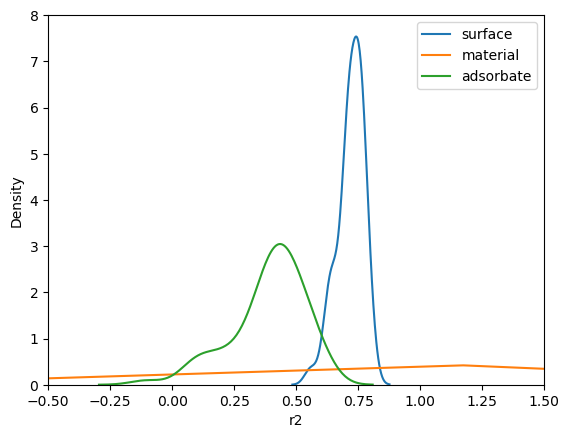

In [100]:
fig, ax =plt.subplots()

sns.kdeplot(dfr_surface, x='r2', legend=True, label='surface', ax=ax)
sns.kdeplot(dfr_material, x='r2', legend=True, label='material',ax=ax)
sns.kdeplot(dfr_adsorbate, x='r2', legend=True, label='adsorbate',ax=ax)

plt.legend()
plt.xlim(-0.5, 1.5)
plt.ylim(0, 8)

101


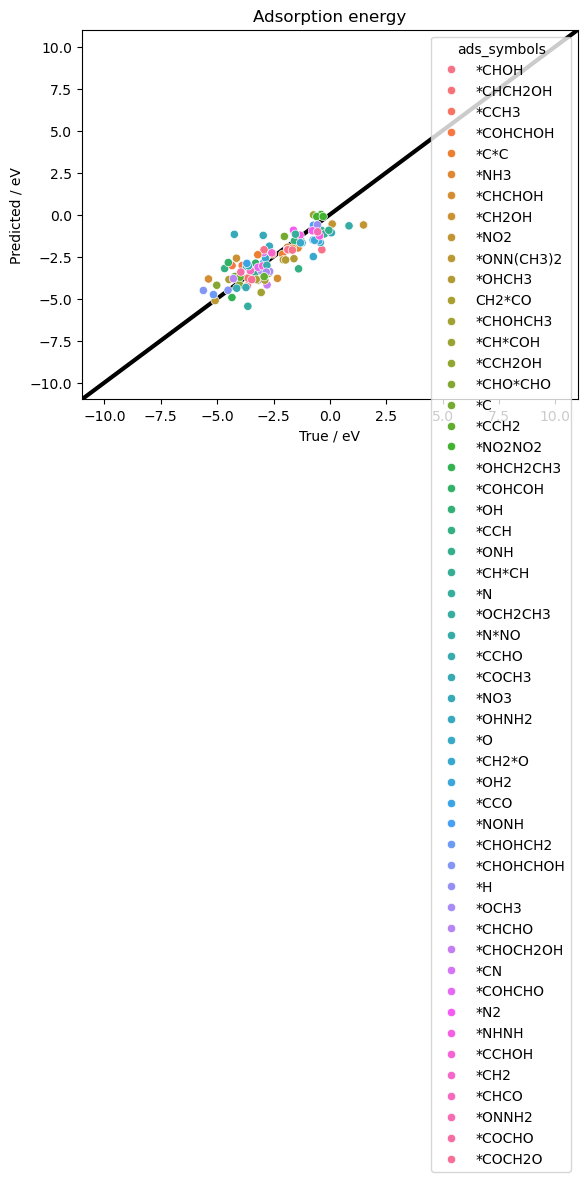

In [53]:
fig, ax = plt.subplots()

material = 'Si8Nb24'
d = df_train_all[df_train_all['bulk_symbols'] == material]
print(len(d))
sns.scatterplot(d, x='eads_eV', y='pred', hue='ads_symbols', ax=ax)

ax.set_xlabel("True / eV")
ax.set_ylabel("Predicted / eV")
ax.set_title("Adsorption energy")
ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)

x = np.linspace(-11, 11, 1000)
y = np.linspace(-11, 11, 1000)

ax.plot(x, y, lw=3, zorder=-1, color='black')

5614


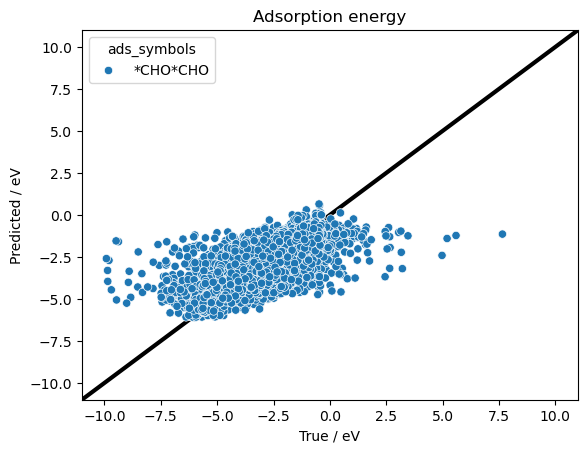

In [45]:
fig, ax = plt.subplots()

d = df_train_all[df_train_all['ads_symbols'] == '*CHO*CHO']
print(len(d))
sns.scatterplot(d, x='eads_eV', y='pred', hue='ads_symbols', ax=ax)

ax.set_xlabel("True / eV")
ax.set_ylabel("Predicted / eV")
ax.set_title("Adsorption energy")
ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)

x = np.linspace(-11, 11, 1000)
y = np.linspace(-11, 11, 1000)

ax.plot(x, y, lw=3, zorder=-1, color='black')

In [1]:
fig, ax = plt.subplots(figsize=(8,8))

sns.kdeplot(df_id, x='error', ax=ax)
sns.kdeplot(df_ood_ads, x='error', ax=ax)
sns.kdeplot(df_ood_cat, x='error', ax=ax)
sns.kdeplot(df_ood_both, x='error', ax=ax)

ax.legend(["id", "ood_ads", "ood_cat", "ood_both"])
ax.set_xlabel("Error / eV")

NameError: name 'plt' is not defined

In [ ]:
df_ood_both.columns

In [ ]:
sns.scatterplot(df_ood_both, x='', y='error')

In [ ]:
df_ood_ads.groupby("ads_size").count()